<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/udl-book/Chapter%2020/20_4_Adversarial_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 20.4: Adversarial attacks**

This notebook builds uses the network for classification of MNIST from Notebook 10.5.  The code is adapted from https://nextjournal.com/gkoehler/pytorch-mnist, and uses the fast gradient sign attack of [Goodfellow et al. (2015)](https://arxiv.org/abs/1412.6572).  Having trained, the network, we search for adversarial examples -- inputs which look very similar to class A, but are mistakenly classified as class B.  We do this by starting with a correctly classified example and perturbing it according to the gradients of the network so that the output changes.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

In [2]:
# Run this once to load the train and test data straight into a dataloader class
# that will provide the batches
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11610810.41it/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 354392.75it/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3209129.08it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7361100.76it/s]


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



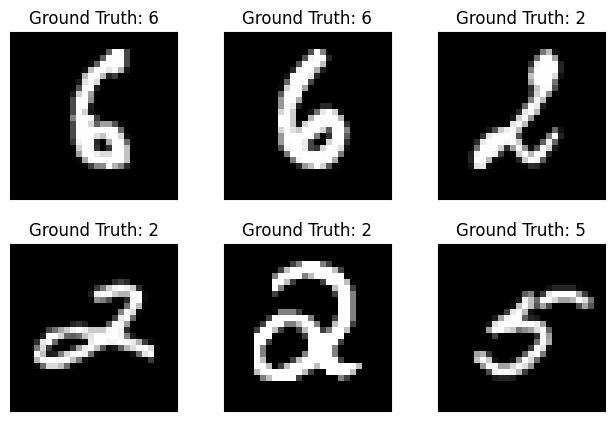

In [3]:
# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

Define the network.  This is a more typical way to define a network than the sequential structure.  We define a class for the network, and define the parameters in the constructor.  Then we use a function called forward to actually run the network.  It's easy to see how you might use residual connections in this format.

In [4]:
from os import X_OK

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.drop(x)
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x)
        return x

In [5]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [6]:
# Create network
model = Net()
# Initialize model weights
model.apply(weights_init)
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [7]:
# Main training routine
def train(epoch):
  model.train()
  # Get each
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    # Store results
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

In [8]:
# Run on test data
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [9]:
# Get initial performance
test()
# Train for three epochs
n_epochs = 3
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-4-44c2b231bb59>:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3752, Accuracy: 1013/10000 (10%)

Train Epoch: 1 [0/60000]	Loss: 2.469849
Train Epoch: 1 [640/60000]	Loss: 2.283326
Train Epoch: 1 [1280/60000]	Loss: 2.217646
Train Epoch: 1 [1920/60000]	Loss: 2.124671
Train Epoch: 1 [2560/60000]	Loss: 2.021610
Train Epoch: 1 [3200/60000]	Loss: 1.910098
Train Epoch: 1 [3840/60000]	Loss: 1.659852
Train Epoch: 1 [4480/60000]	Loss: 1.478240
Train Epoch: 1 [5120/60000]	Loss: 1.237303
Train Epoch: 1 [5760/60000]	Loss: 1.195786
Train Epoch: 1 [6400/60000]	Loss: 1.118826
Train Epoch: 1 [7040/60000]	Loss: 1.007379
Train Epoch: 1 [7680/60000]	Loss: 1.223586
Train Epoch: 1 [8320/60000]	Loss: 0.734254
Train Epoch: 1 [8960/60000]	Loss: 1.016466
Train Epoch: 1 [9600/60000]	Loss: 0.749474
Train Epoch: 1 [10240/60000]	Loss: 0.685178
Train Epoch: 1 [10880/60000]	Loss: 0.677596
Train Epoch: 1 [11520/60000]	Loss: 0.600323
Train Epoch: 1 [12160/60000]	Loss: 0.729888
Train Epoch: 1 [12800/60000]	Loss: 0.409651
Train Epoch: 1 [13440/60000]	Loss: 0.5

<ipython-input-4-44c2b231bb59>:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


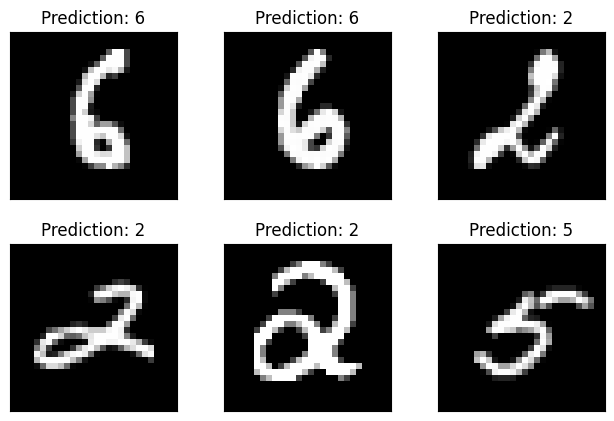

In [10]:
# Run network on data we got before and show predictions
output = model(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()

This is the code that does the adversarial attack. It is adapted from [here](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html).   It is an example of the fast gradient sign method (FGSM), which modifies the data by



*   Calculating the derivative $\partial L/\partial \mathbf{x}$ of the loss $L$ with respect to the input data $\mathbf{x}$.
*   Finds the sign of the gradient at each point (making a tensor the same size as $\mathbf{x}$ with a one where it was positive and minus one where it was negative.  
*   Multiplying this vector by $\epsilon$ and adding it back to the original data




In [13]:
# FGSM attack code.
def fgsm_attack(x, epsilon, dLdx):
    # TODO -- write this function
    # Get the sign of the gradient
    sign_data_grad = dLdx.sign()

    # Replace this line
    x_modified = x + epsilon*sign_data_grad

    # Return the perturbed image
    return x_modified

<ipython-input-4-44c2b231bb59>:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


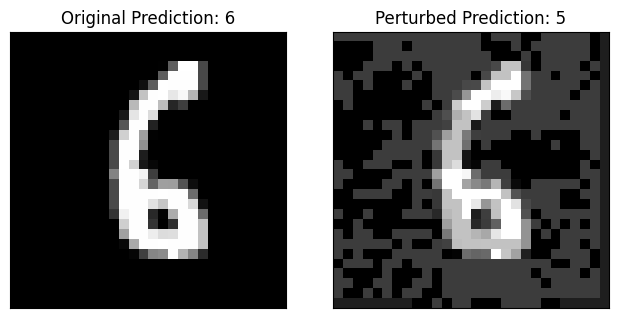

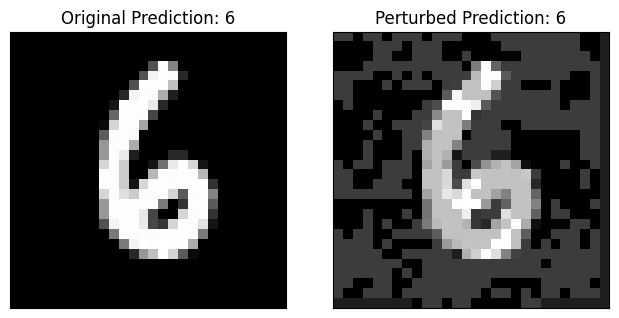

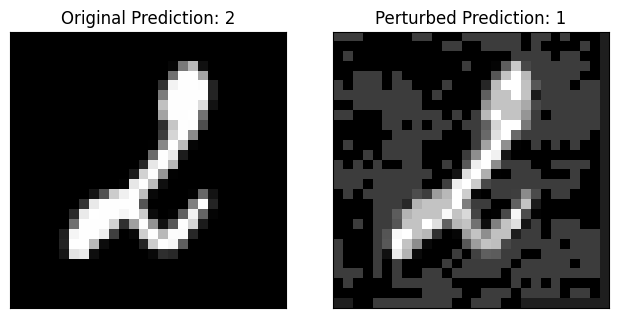

In [14]:
no_examples = 3
epsilon = 0.5
for i in range(no_examples):
  # Reset gradients
  optimizer.zero_grad()

  # Get the i'th data example
  x = example_data[i,:,:,:]
  # Add an extra dimension back to the beginning
  x= x[None, :,:,:]
  x.requires_grad = True
  # Get the i'th target
  y = torch.ones(1, dtype=torch.long) * example_targets[i]

  # Run the model
  output = model(x)
  # Compute the loss
  loss = F.nll_loss(output, y)
  # Back propagate
  loss.backward()

  # Collect ``datagrad``
  dLdx = x.grad.data

  # Call FGSM Attack
  x_prime = fgsm_attack(x, epsilon, dLdx)

  # Re-classify the perturbed image
  output_prime = model(x_prime)

  x = x.detach().numpy()
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.tight_layout()
  plt.imshow(x[0][0], cmap='gray', interpolation='none')
  plt.title("Original Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][0].item()))
  plt.xticks([])
  plt.yticks([])

  plt.subplot(1,2,2)
  plt.tight_layout()
  plt.imshow(x_prime[0][0].detach().numpy(), cmap='gray', interpolation='none')
  plt.title("Perturbed Prediction: {}".format(
    output_prime.data.max(1, keepdim=True)[1][0].item()))
  plt.xticks([])
  plt.yticks([])

plt.show()

Although we have only added a small amount of noise, the model is fooled into thinking that these images come from a different class.

TODO -- Modify the attack so that it iteratively perturbs the data. i.e., so we take a small step epsilon, then re-calculate the gradient and take another small step according to the new gradient signs.